
Temps GPU v0 (non optimisé) : 14722.038 ms


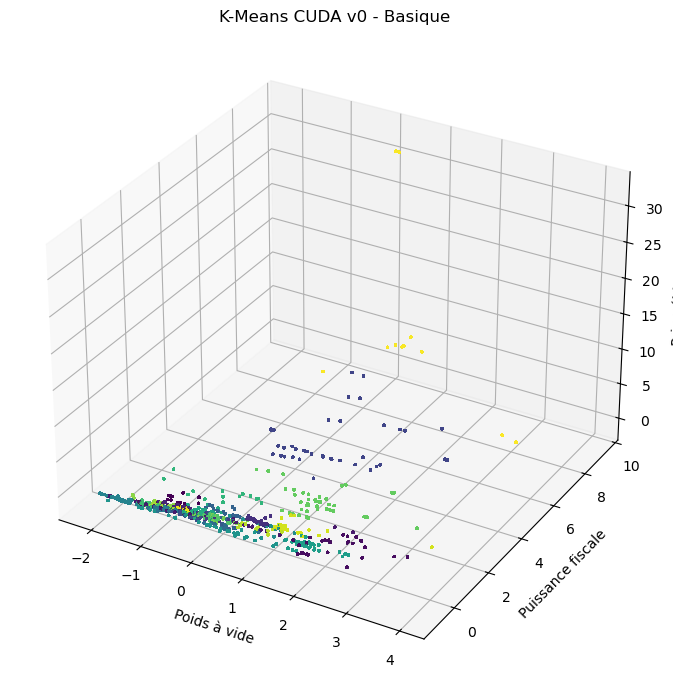


Moyennes des clusters :
         Poids à vide  Puissance fiscale  Prix véhicule    Cylindrée  \
Cluster                                                                
0         1252.202532           9.683544   35843.594937  1942.012658   
1         2191.000000           7.648649   94061.918919     0.000000   
2         1413.633929           6.794643   36363.910714  1895.366071   
3         1295.807843           7.360784   35310.529412  1474.513725   
4         1729.274775          10.247748   56889.878378  1985.468468   
5         1471.380282           7.169014   35030.000000  1451.732394   
6         1781.247619          43.180952  149135.866667  3320.942857   
7         1362.761468           5.458716   32420.660550  1531.522936   
8         1622.480769           6.288462   37051.307692  1968.000000   
9         1548.661157           9.652893   49502.115702  1980.690083   
10        1561.809524           5.333333   33027.428571  1473.317460   
11        1201.831169           5.24675

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math
from sklearn.preprocessing import StandardScaler

# Chargement des données
colonnes_utiles = ['Poids à vide', 'Puissance fiscale', 'Prix véhicule',
                   'Cylindrée', 'Rapport poids-puissance', 'Nombre rapports']
df = pd.read_csv("../data/ADEME-CarLabelling.csv", sep=';', encoding='utf-8')
df = df[colonnes_utiles]  # S'assurer de ne garder que les colonnes utiles
for col in colonnes_utiles:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')
df = df.dropna()
df = df[(df['Poids à vide'] > 400) & (df['Puissance fiscale'] > 1) & (df['Prix véhicule'] > 1000)]

if df.empty:
    raise ValueError("Le DataFrame est vide après nettoyage. Vérifiez les filtres ou les données.")

df = pd.concat([df] * 200, ignore_index=True)

X = df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

n_samples, n_features = X_scaled.shape
k = 30
max_iter = 100
np.random.seed(42)
centroids = X_scaled[np.random.choice(n_samples, k, replace=False)]

# Kernel simple sans optimisation
@cuda.jit
def assign_clusters_basic(data, centroids, labels):
    i = cuda.grid(1)
    if i < data.shape[0]:
        min_dist = 1e10
        best = -1
        for c in range(centroids.shape[0]):
            dist = 0.0
            for f in range(data.shape[1]):
                tmp = data[i, f] - centroids[c, f]
                dist += tmp * tmp
            if dist < min_dist:
                min_dist = dist
                best = c
        labels[i] = best

# Allocation GPU
d_data = cuda.to_device(X_scaled)
d_labels = cuda.device_array(n_samples, dtype=np.int32)
threads_per_block = 128
blocks_per_grid = math.ceil(n_samples / threads_per_block)

# Chrono GPU
start = cuda.event()
end = cuda.event()
start.record()

for _ in range(max_iter):
    d_centroids = cuda.to_device(centroids)
    assign_clusters_basic[blocks_per_grid, threads_per_block](d_data, d_centroids, d_labels)
    labels = d_labels.copy_to_host()

    new_centroids = np.zeros_like(centroids)
    counts = np.zeros(k)
    for i in range(n_samples):
        new_centroids[labels[i]] += X_scaled[i]
        counts[labels[i]] += 1
    for j in range(k):
        if counts[j] > 0:
            new_centroids[j] /= counts[j]

    if np.allclose(centroids, new_centroids, atol=1e-2):
        break
    centroids = new_centroids

end.record()
end.synchronize()
elapsed = cuda.event_elapsed_time(start, end)
print(f"\nTemps GPU v0 (non optimisé) : {elapsed:.3f} ms")

# Affichage 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=labels, cmap='viridis', s=1)
ax.set_title("K-Means CUDA v0 - Basique")
ax.set_xlabel("Poids à vide")
ax.set_ylabel("Puissance fiscale")
ax.set_zlabel("Prix véhicule")
plt.tight_layout()
plt.show()

# Analyse des clusters
df['Cluster'] = labels
print("\nMoyennes des clusters :")
print(df.groupby('Cluster')[colonnes_utiles].mean())

